## 목적
본 파일은 최근 4개년(5개년) 기준 강팀(LG, SSG, KIA)의 공통 구조를 모델링하고,
이를 한화와 비교하여
2025년 성과를 유지·강화하기 위한 전략적 시사점을 도출하는 것을 목표로 한다.

- 선수 단위 분석 ❌
- 팀 단위 대표값 기반 비교 ⭕️
- 설명 중심 분석 (컨설팅형 HOW)

In [25]:
import pandas as pd
import numpy as np

In [26]:
bat = pd.read_csv("../data/processed/bat_analysis_pa50_2022_2025.csv")
pitch = pd.read_csv("../data/processed/pitch_analysis_ip30_2022_2025.csv")
win = pd.read_csv("../data/team_win_rate_2022_2025.csv")

In [27]:
print(bat.columns)
print(pitch.columns)

Index(['Id', 'Name', 'Birthdate', 'Handedness', 'School', 'Draft', 'Year',
       'Team', 'Age', 'Pos.', 'G', 'oWAR', 'dWAR', 'PA', 'ePA', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'TB', 'RBI', 'SB', 'CS', 'BB', 'HP', 'IB', 'SO',
       'GDP', 'SH', 'SF', 'AVG', 'OBP', 'SLG', 'OPS', 'R/ePA', 'wRC+', 'WAR'],
      dtype='object')
Index(['Id', 'Name', 'Birthdate', 'Handedness', 'School', 'Draft', 'Year',
       'Team', 'Age', 'Pos.', 'G', 'GS', 'GR', 'GF', 'CG', 'SHO', 'W', 'L',
       'S', 'HD', 'IP', 'ER', 'R', 'rRA', 'TBF', 'H', '2B', '3B', 'HR', 'BB',
       'HP', 'IB', 'SO', 'ROE', 'BK', 'WP', 'ERA', 'RA9', 'rRA9', 'FIP',
       'WHIP', 'WAR'],
      dtype='object')


In [28]:
bat['BB_HBP_PA'] = (bat['BB'] + bat['HP']) / bat['PA']
bat['SO_PA'] = bat['SO'] / bat['PA']
bat['ISO'] = bat['SLG'] - bat['AVG']

In [29]:
pitch['K_BB_pct'] = (pitch['SO'] - pitch['BB'] - pitch['HP']) / pitch['TBF']

In [30]:
bat_use = bat[['Team', 'Year', 'PA', 'OBP', 'BB_HBP_PA', 'SO_PA', 'ISO']]
pitch_use = pitch[['Team', 'Year', 'TBF', 'ERA', 'FIP', 'K_BB_pct']]

In [31]:
# 0) 안전장치
bat = bat[bat['PA'] > 0].copy()

# 1) 파생 지표 생성
bat['BB_HBP_PA'] = (bat['BB'] + bat['HP']) / bat['PA']
bat['SO_PA'] = bat['SO'] / bat['PA']
bat['ISO'] = bat['SLG'] - bat['AVG']

# 2) 필요한 컬럼만 추출
bat_use = bat[['Team', 'Year', 'PA', 'OBP', 'BB_HBP_PA', 'SO_PA', 'ISO']].copy()

# 3) PA 가중 평균 (apply 없이)
bat_team_year = (
    bat_use
    .assign(
        OBP_w = bat_use['OBP'] * bat_use['PA'],
        BB_HBP_PA_w = bat_use['BB_HBP_PA'] * bat_use['PA'],
        SO_PA_w = bat_use['SO_PA'] * bat_use['PA'],
        ISO_w = bat_use['ISO'] * bat_use['PA']
    )
    .groupby(['Team', 'Year'], as_index=False)
    .agg({
        'OBP_w': 'sum',
        'BB_HBP_PA_w': 'sum',
        'SO_PA_w': 'sum',
        'ISO_w': 'sum',
        'PA': 'sum'
    })
    .assign(
        OBP = lambda x: x['OBP_w'] / x['PA'],
        BB_HBP_PA = lambda x: x['BB_HBP_PA_w'] / x['PA'],
        SO_PA = lambda x: x['SO_PA_w'] / x['PA'],
        ISO = lambda x: x['ISO_w'] / x['PA']
    )
    [['Team', 'Year', 'OBP', 'BB_HBP_PA', 'SO_PA', 'ISO']]
)

bat_team_year.head(20)


,Team,Year,OBP,BB_HBP_PA,SO_PA,ISO
0,KIA,2022,0.350761,0.106375,0.170485,0.125904
1,KIA,2023,0.348508,0.097960,0.167065,0.116948
2,KIA,2024,0.369911,0.101644,0.155559,0.159096
3,KIA,2025,0.337021,0.105465,0.214038,0.143344
4,LG,2022,0.347170,0.107720,0.163914,0.128913
5,LG,2023,0.365355,0.116724,0.137881,0.116483
6,LG,2024,0.369162,0.120556,0.167118,0.131319
7,LG,2025,0.362918,0.117985,0.168191,0.132017
8,SSG,2022,0.338931,0.111477,0.188724,0.144439
9,SSG,2023,0.339306,0.104923,0.164669,0.132781


In [32]:
strong_teams = ['LG', 'SSG', 'KIA']
target_team = '한화'
years = [2022, 2023, 2024, 2025]

In [33]:
bat_strong = bat_team_year[
    (bat_team_year['Team'].isin(strong_teams)) &
    (bat_team_year['Year'].isin(years))
].copy()

strong_team_off = (
    bat_strong
    .groupby('Team', as_index=True)[['OBP', 'BB_HBP_PA', 'SO_PA', 'ISO']]
    .mean()
)

strong_team_off

,OBP,BB_HBP_PA,SO_PA,ISO
Team,,,,
KIA,0.351550,0.102861,0.176787,0.136323
LG,0.361151,0.115746,0.159276,0.127183
SSG,0.338215,0.103109,0.188625,0.136597


In [34]:
strong_off_model = strong_team_off.mean()
strong_off_model

OBP          0.350305
BB_HBP_PA    0.107239
SO_PA        0.174896
ISO          0.133368
dtype: float64

In [35]:
hanwha_off = (
    bat_team_year[
        (bat_team_year['Team'] == target_team) &
        (bat_team_year['Year'].isin(years))
    ][['OBP', 'BB_HBP_PA', 'SO_PA', 'ISO']]
    .mean()
)

hanwha_off


OBP          0.334252
BB_HBP_PA    0.104383
SO_PA        0.200106
ISO          0.119209
dtype: float64

In [36]:
compare_off = pd.DataFrame({
    'Strong_Team_Model': strong_off_model,
    'Hanwha': hanwha_off
})

compare_off['Difference(Hanwha-Model)'] = compare_off['Hanwha'] - compare_off['Strong_Team_Model']
compare_off


,Strong_Team_Model,Hanwha,Difference(Hanwha-Model)
OBP,0.350305,0.334252,-0.016054
BB_HBP_PA,0.107239,0.104383,-0.002856
SO_PA,0.174896,0.200106,0.025210
ISO,0.133368,0.119209,-0.014159


Text(0, 0.5, 'Value')

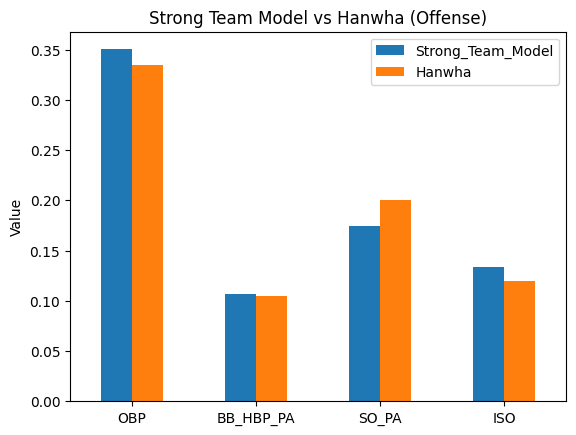

In [37]:
ax = compare_off[['Strong_Team_Model', 'Hanwha']].plot(kind='bar', rot=0)
ax.set_title('Strong Team Model vs Hanwha (Offense)')
ax.set_ylabel('Value')


In [38]:
hanwha_year = bat_team_year[
    (bat_team_year['Team'] == target_team) &
    (bat_team_year['Year'].isin(years))
][['Year', 'OBP', 'BB_HBP_PA', 'SO_PA', 'ISO']].sort_values('Year')

hanwha_year


,Year,OBP,BB_HBP_PA,SO_PA,ISO
12,2022,0.322693,0.101730,0.224520,0.107269
13,2023,0.327517,0.111577,0.205105,0.110926
14,2024,0.348772,0.108132,0.187500,0.129251
15,2025,0.338025,0.096093,0.183299,0.129389


In [39]:
hanwha_year[['OBP', 'BB_HBP_PA', 'SO_PA', 'ISO']].corr()

,OBP,BB_HBP_PA,SO_PA,ISO
OBP,1.000000,0.022473,-0.858268,0.922439
BB_HBP_PA,0.022473,1.000000,0.163090,-0.307757
SO_PA,-0.858268,0.163090,1.000000,-0.948943
ISO,0.922439,-0.307757,-0.948943,1.000000


In [40]:
compare_off

,Strong_Team_Model,Hanwha,Difference(Hanwha-Model)
OBP,0.350305,0.334252,-0.016054
BB_HBP_PA,0.107239,0.104383,-0.002856
SO_PA,0.174896,0.200106,0.025210
ISO,0.133368,0.119209,-0.014159


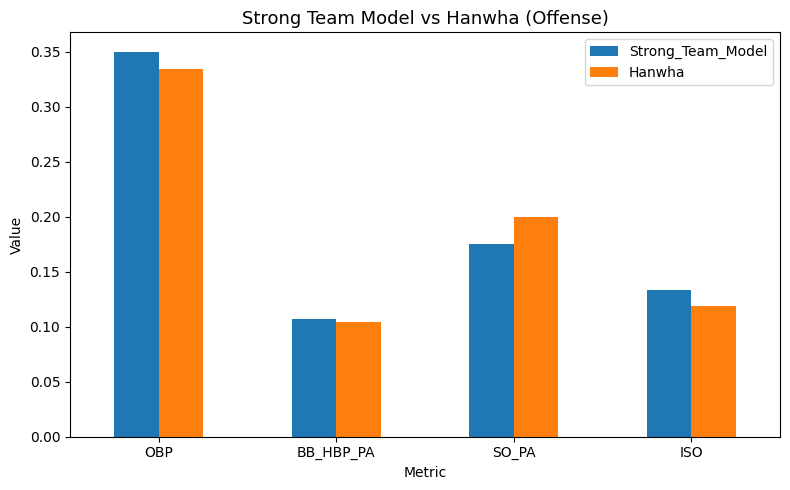

In [41]:
import matplotlib.pyplot as plt

ax = compare_off[['Strong_Team_Model', 'Hanwha']].plot(
    kind='bar',
    figsize=(8, 5),
    rot=0
)

ax.set_title('Strong Team Model vs Hanwha (Offense)', fontsize=13)
ax.set_ylabel('Value')
ax.set_xlabel('Metric')
plt.tight_layout()
plt.show()


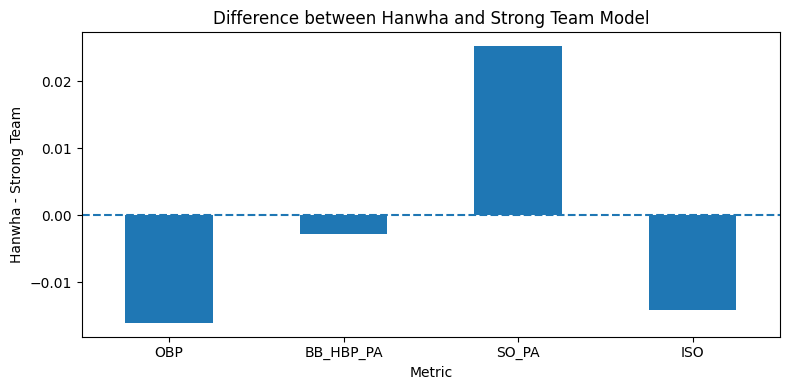

In [42]:
ax = compare_off['Difference(Hanwha-Model)'].plot(
    kind='bar',
    figsize=(8, 4),
    rot=0
)

ax.axhline(0, linestyle='--')
ax.set_title('Difference between Hanwha and Strong Team Model')
ax.set_ylabel('Hanwha - Strong Team')
ax.set_xlabel('Metric')
plt.tight_layout()
plt.show()


2️⃣ 첫 번째 / 두 번째 막대그래프 해석
(Strong Team Model vs Hanwha)
이 두 그래프는 같은 내용을 다른 스타일로 표현한 것이라,
실제 해석은 같이 묶어서 설명하면 됨
🔹 OBP (출루율)
Strong Team Model > 한화
차이는 크지 않지만 일관되게 강팀이 높음
📌 해석 멘트:
“한화는 출루율 측면에서 강팀 평균에 근접해 있으나, 여전히 소폭 열세입니다.”
🔹 BB_HBP_PA (볼넷+몸맞는공 비율)
거의 동일
차이가 매우 미미
📌 해석 멘트:
“선구안 자체는 강팀과 큰 차이가 없습니다.”
👉 이거 되게 중요함
→ ‘출루를 못한다’기보다, 출루 이후의 효율 문제가 핵심이라는 근거
🔹 SO_PA (삼진 비율)
한화가 더 높음 (눈에 띄게)
이 그래프의 가장 중요한 포인트
📌 해석 멘트:
“한화는 강팀 대비 삼진 비율이 높아, 공격 흐름이 자주 끊기는 구조를 보입니다.”
🔹 ISO (순수 장타력)
Strong Team Model > 한화
장타력에서 명확한 격차
📌 해석 멘트:
“장타 생산력에서 한화는 강팀 평균보다 낮은 수준입니다.”
3️⃣ 🔥 Difference 그래프 (핵심 요약 그래프)
이 그래프 하나로 모든 설명이 끝난다고 봐도 됨.
축 해석
0 기준선
위: 한화가 강팀보다 우위
아래: 강팀이 우위
지표별 해석
⬇️ OBP (음수)
출루율이 강팀 평균보다 낮음
“출루에서부터 이미 약간의 열세가 존재”
⬇️ BB_HBP_PA (거의 0, 약간 음수)
선구안 차이는 거의 없음
“문제의 핵심은 볼넷이 아니라 이후 결과”
⬆️ SO_PA (양수, 가장 큼)
한화의 구조적 약점
공격 효율 저하의 핵심 원인
“삼진이 많아 득점 연결이 어렵다”
⚠️ 여기서 중요한 포인트
👉 SO_PA는 ‘낮을수록 좋은 지표’
→ 양수라는 건 명확한 약점
⬇️ ISO (음수)
장타력 부족
“출루 이후에도 장타로 연결되지 못하는 구조”
4️⃣ 이 그래프들이 말해주는 한 문장 결론
“한화는 선구안 자체는 강팀과 큰 차이가 없지만,
삼진이 많고 장타력이 부족해 출루가 득점으로 연결되지 않는 공격 구조를 보인다.”
이 문장 하나로 그래프 3개를 전부 설명 가능.
5️⃣ 발표/보고에서 이렇게 말하면 최고다 (추천 스크립트)
“한화는 볼넷과 몸맞는공 비율에서는 강팀과 거의 차이가 없습니다.
하지만 삼진 비율이 높고, 장타력이 낮아 공격 흐름이 자주 끊깁니다.
즉, 출루 능력보다 출루 이후의 생산성 문제가 구조적인 약점으로 보입니다.”
6️⃣ (보너스) 누가 뭐라 태클 걸면 이렇게 방어하면 됨
❓ “삼진 많은 게 꼭 문제인가요?”
→ “SO_PA는 낮을수록 좋은 지표이며, 득점 기대값과 음의 관계가 강합니다.”
❓ “BB 비슷한데 왜 OBP 차이나요?”
→ “장타 부족과 삼진 증가가 출루 이후 기대 득점을 낮춥니다.”

### 🔵 Pitch Structure Modeling — Strong Team Benchmark

앞선 공격 분석과 동일한 방식으로  
투수 지표에서도 강팀(LG, SSG, KIA)의 평균 구조를 기준선으로 설정한다.

- 분석 목적  
  - 한화의 투수 구조가 강팀 평균과 얼마나 유사한지 확인
  - 성과가 특정 지표에 과도하게 의존하는지 점검

- 사용 지표  
  - ERA : 실점 기반 성과
  - FIP : 수비·운 영향을 제거한 투수 실력 지표
  - K-BB% : 투수 지배력 핵심 지표

모든 비교는 팀-연도 단위 평균을 기반으로 수행한다.

In [43]:
# =========================
# Pitch: Team-Year Structure
# =========================

# 0) 안전장치
pitch = pitch[pitch['TBF'] > 0].copy()

# 1) 필요한 컬럼만 사용
pitch_use = pitch[['Team', 'Year', 'TBF', 'ERA', 'FIP', 'K_BB_pct']].copy()

# 2) 팀-연도 단위 평균
# (ERA, FIP, K-BB%는 이미 비율/지표이므로 단순 평균 사용)
pitch_team_year = (
    pitch_use
    .groupby(['Team', 'Year'], as_index=False)
    .mean()
)

pitch_team_year.head()


,Team,Year,TBF,ERA,FIP,K_BB_pct
0,KIA,2022,362.615385,4.008462,4.010000,0.091424
1,KIA,2023,309.562500,4.116250,4.420000,0.052202
2,KIA,2024,296.941176,4.413529,4.735294,0.094129
3,KIA,2025,338.928571,4.666429,4.432143,0.088493
4,LG,2022,307.250000,3.137500,3.750000,0.095587


### 🔵 Pitch Strong Team Model

공격 분석과 동일하게  
최근 성과가 우수했던 LG, SSG, KIA를 강팀으로 정의하고  
이들의 평균 투수 구조를 Strong Team Model로 설정한다.

In [44]:
# Strong teams 기준
pitch_strong = pitch_team_year[
    (pitch_team_year['Team'].isin(strong_teams)) &
    (pitch_team_year['Year'].isin(years))
].copy()

# 팀별 평균
strong_team_pitch = (
    pitch_strong
    .groupby('Team', as_index=True)[['ERA', 'FIP', 'K_BB_pct']]
    .mean()
)

strong_team_pitch


,ERA,FIP,K_BB_pct
Team,,,
KIA,4.301167,4.399359,0.081562
LG,3.746168,4.071064,0.092753
SSG,4.254205,4.456108,0.085096


In [45]:
# Strong Team Model (3팀 평균)
strong_pitch_model = strong_team_pitch.mean()
strong_pitch_model


ERA         4.100514
FIP         4.308844
K_BB_pct    0.086470
dtype: float64

### 🔵 Hanwha vs Strong Team Model (Pitch)

한화의 투수 지표를 Strong Team Model과 비교하여  
강점과 개선 여지를 구조적으로 확인한다.


In [46]:
# 한화 평균
hanwha_pitch = (
    pitch_team_year[
        (pitch_team_year['Team'] == target_team) &
        (pitch_team_year['Year'].isin(years))
    ][['ERA', 'FIP', 'K_BB_pct']]
    .mean()
)

hanwha_pitch


ERA         4.433862
FIP         4.365063
K_BB_pct    0.083768
dtype: float64

In [47]:
# 비교 테이블
compare_pitch = pd.DataFrame({
    'Strong_Team_Model': strong_pitch_model,
    'Hanwha': hanwha_pitch
})

compare_pitch['Difference(Hanwha-Model)'] = (
    compare_pitch['Hanwha'] - compare_pitch['Strong_Team_Model']
)

compare_pitch


,Strong_Team_Model,Hanwha,Difference(Hanwha-Model)
ERA,4.100514,4.433862,0.333348
FIP,4.308844,4.365063,0.056219
K_BB_pct,0.086470,0.083768,-0.002702


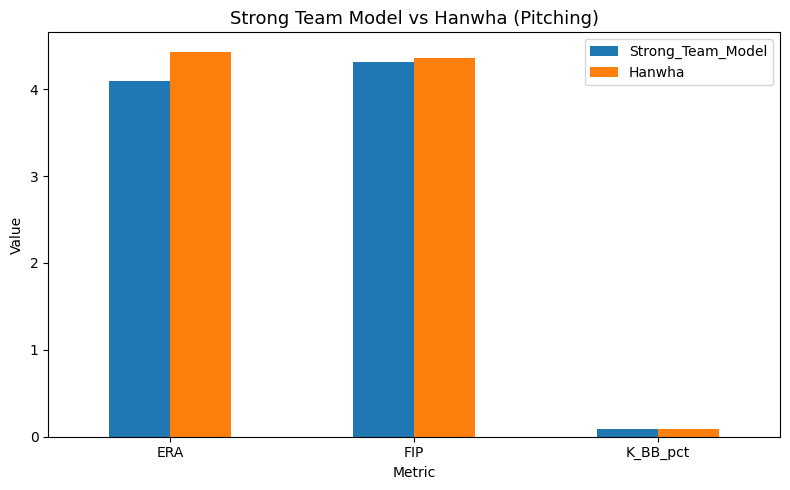

In [48]:
# Strong Team vs Hanwha
ax = compare_pitch[['Strong_Team_Model', 'Hanwha']].plot(
    kind='bar',
    figsize=(8, 5),
    rot=0
)

ax.set_title('Strong Team Model vs Hanwha (Pitching)', fontsize=13)
ax.set_ylabel('Value')
ax.set_xlabel('Metric')
plt.tight_layout()
plt.show()


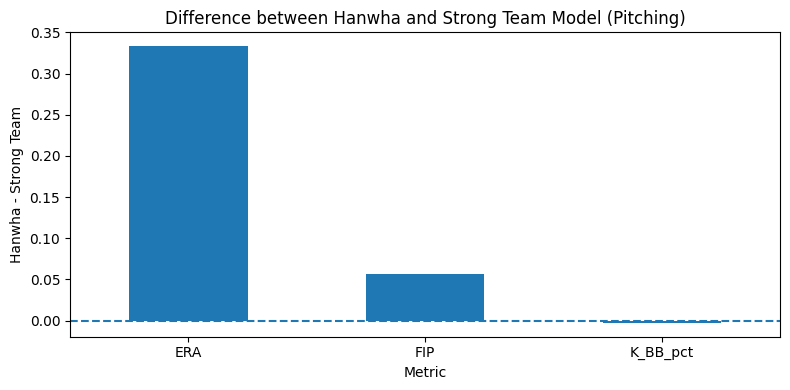

In [49]:
# Difference 그래프
ax = compare_pitch['Difference(Hanwha-Model)'].plot(
    kind='bar',
    figsize=(8, 4),
    rot=0
)

ax.axhline(0, linestyle='--')
ax.set_title('Difference between Hanwha and Strong Team Model (Pitching)')
ax.set_ylabel('Hanwha - Strong Team')
ax.set_xlabel('Metric')
plt.tight_layout()
plt.show()


### 🔎 Pitch Model Interpretation Guide

- ERA / FIP  
  - 0보다 크면 한화가 강팀 대비 열세
  - 0보다 작으면 강팀 대비 우위

- K-BB%  
  - 높을수록 투수 지배력이 우수
  - 한화가 강팀 평균에 근접하거나 상회한다면
    → 투수 성과의 지속 가능성 근거로 해석 가능
